# QC, normalization to UMAP of microtissue (cDNA5) samples from shallow sequencing
### By Maks Necki
### __10.02.2026__

###### Loading required libraries:

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import scipy as sp
import scipy.stats as stats
import logging
import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

###### Loading count matrix:

In [240]:
adatas = [
    sc.read_10x_h5(filename = "/mnt/dysk_D/NIKARD_35_probek/demultiplex_results/cDNA5_OCM_demux/outs/per_sample_outs/Sample1/count/sample1_filtered_feature_bc_matrix.h5"),
    sc.read_10x_h5(filename = "/mnt/dysk_D/NIKARD_35_probek/demultiplex_results/cDNA5_OCM_demux/outs/per_sample_outs/Sample2/count/sample2_filtered_feature_bc_matrix.h5"),
    sc.read_10x_h5(filename = "/mnt/dysk_D/NIKARD_35_probek/demultiplex_results/cDNA5_OCM_demux/outs/per_sample_outs/Sample3/count/sample3_filtered_feature_bc_matrix.h5"),
    sc.read_10x_h5(filename = "/mnt/dysk_D/NIKARD_35_probek/demultiplex_results/cDNA5_OCM_demux/outs/per_sample_outs/Sample4/count/sample4_filtered_feature_bc_matrix.h5")
]

/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/anndata/_

###### Generating unique gene names:

In [241]:
for ad in adatas:
    ad.var_names_make_unique()

###### Adding sample ID

In [242]:
for i, ad in enumerate(adatas):
    ad.obs["sample"] = f"sample_{i+1}"

###### Adding metadata:

In [8]:
adata.obs["cell_type_expected"] = adata.obs["sample"].map({
    "sample_1": "CM",
    "sample_2": "FB",
    "sample_3": "FB",
    "sample_4": "CM+FB"
})

adata.obs["culture_dim"] = adata.obs["sample"].map({
    "sample_1": "2D",
    "sample_2": "2D",
    "sample_3": "3D",
    "sample_4": "3D"
})

NameError: name 'adata' is not defined

###### concatenate:

In [243]:
adata = sc.concat(
    adatas,
    join="outer",
    axis=0,
    label="sample",
    keys=["CM_2D", "FB_2D", "FB_3D", "CM_FB_3D"],
    index_unique="-"
)

###### Filtering low quality cells:

In [244]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.startswith(("HB[^(P)]"))

###### We can now calculate the respective QC metrics with scanpy:

In [245]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 18036 × 38606
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

###### We want to highlight by several plots low quality of cells:
###### - `n_genes_by_counts` in `.obs` is the number of genes with positive counts in a cell
###### - `total_counts` is the total number of counts for a cell, this might be known as a library size
###### - `pct_counts_mt` is the proportion of total counts for a cell which are mitochondrial

###### `pct_counts`:

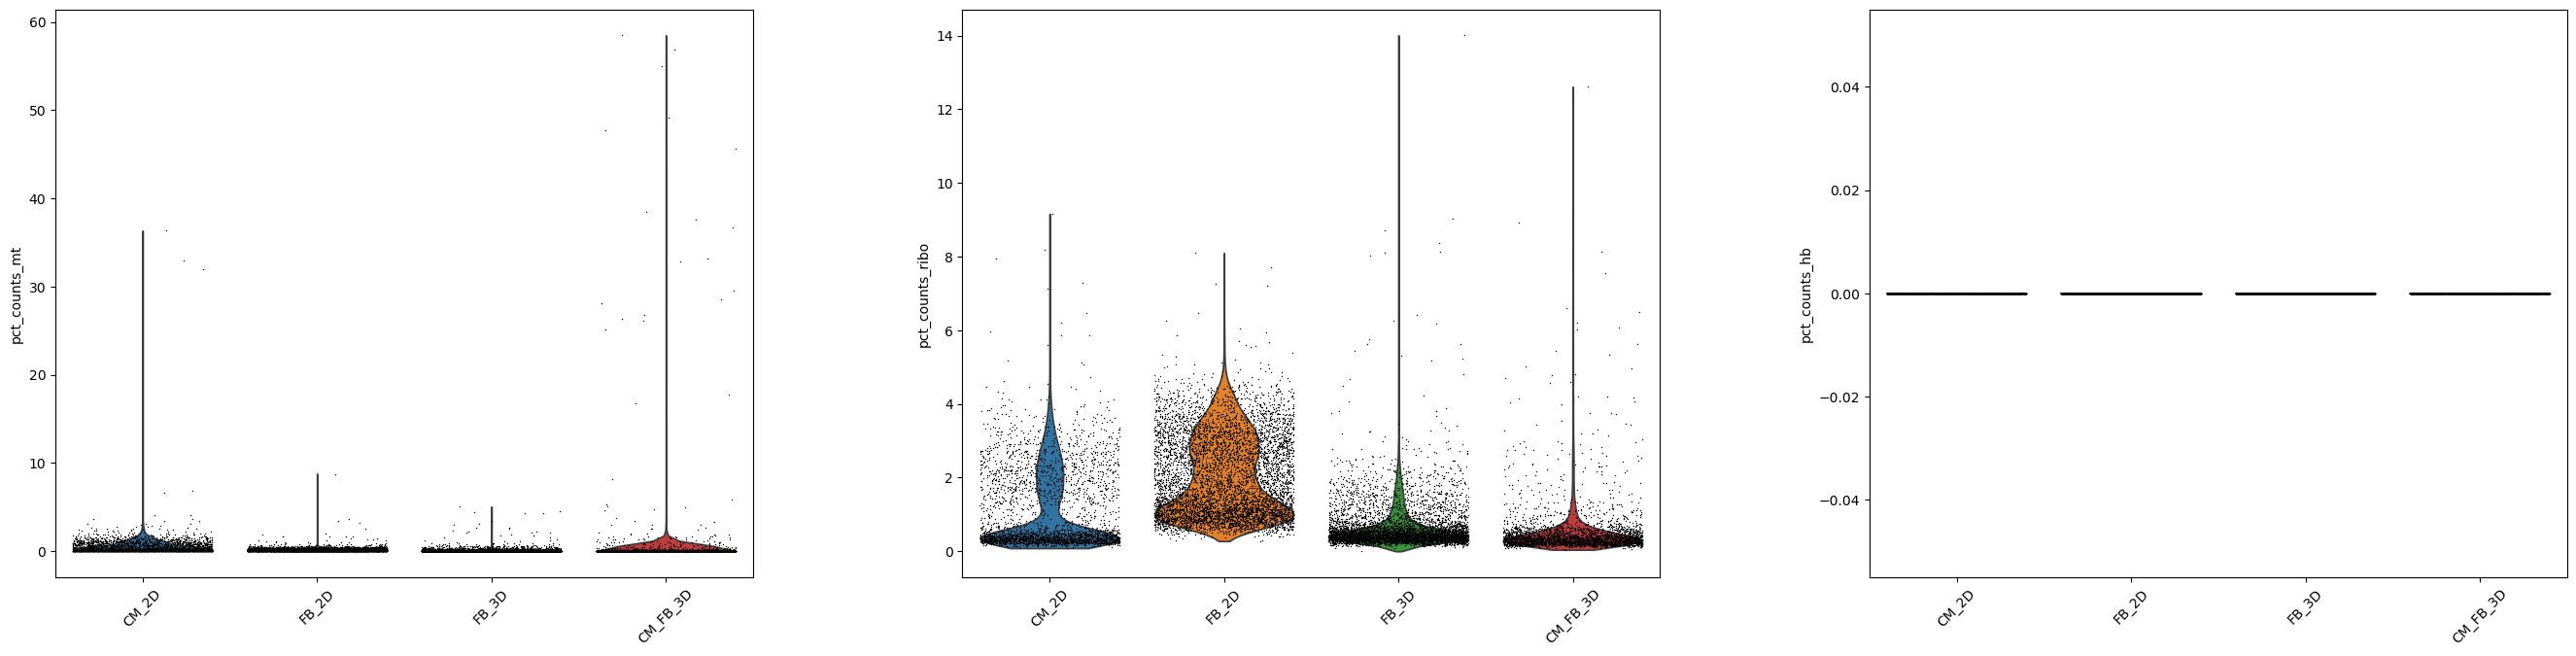

In [129]:
plt.rcParams["figure.figsize"] = (8,8)
sc.pl.violin(
    adata,
    ["pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    groupby="sample",
    jitter=0.4,
    rotation = 45
)

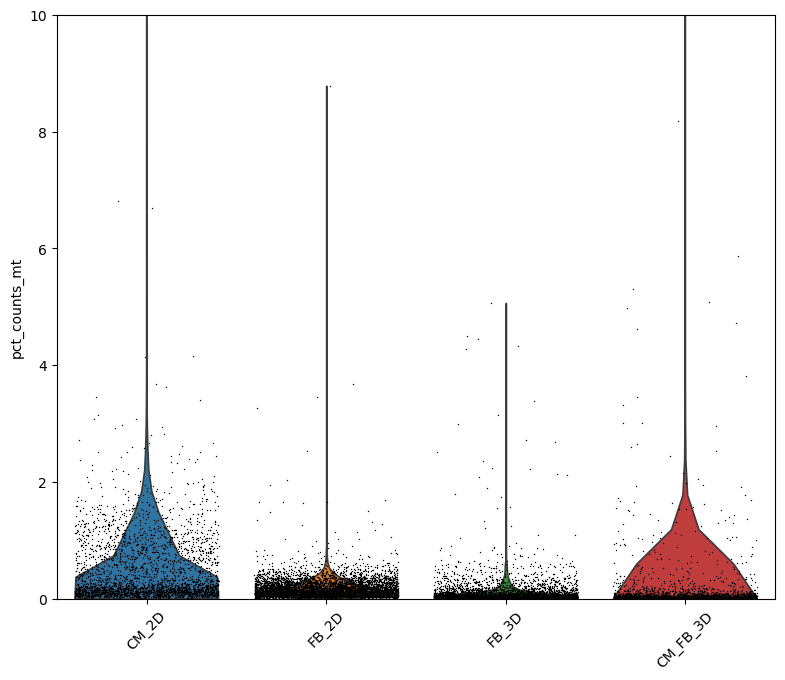

In [130]:
ax = sc.pl.violin(
    adata,
    ["pct_counts_mt"],
    groupby="sample",
    jitter=0.4,
    rotation=45,
    show=False
)

# ustawiamy limit osi Y
ax.set_ylim(0, 10)

plt.show()

###### `total_counts`:

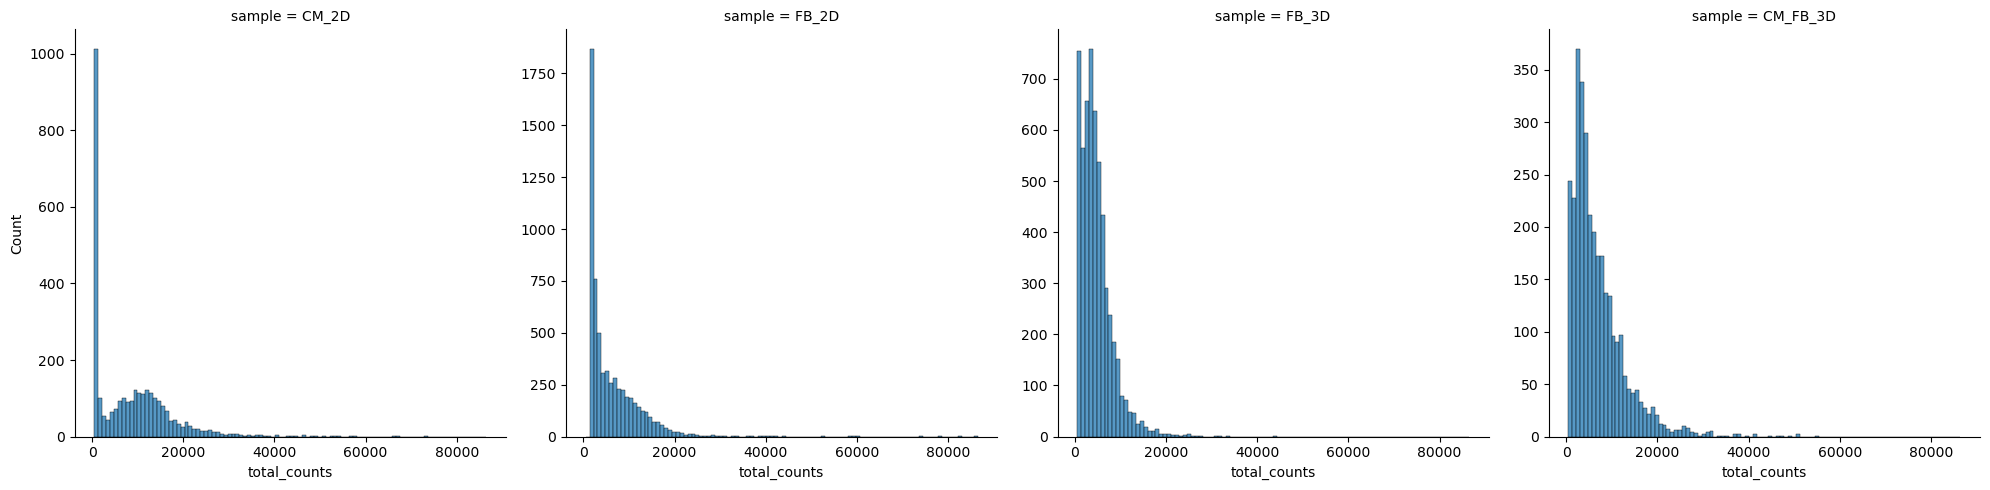

In [131]:
sns.displot(
    data=adata.obs,
    x="total_counts",
    col="sample",
    bins=100,
    facet_kws=dict(sharex=False, sharey=False)
)
plt.show()

###### `n_genes_by_counts`:

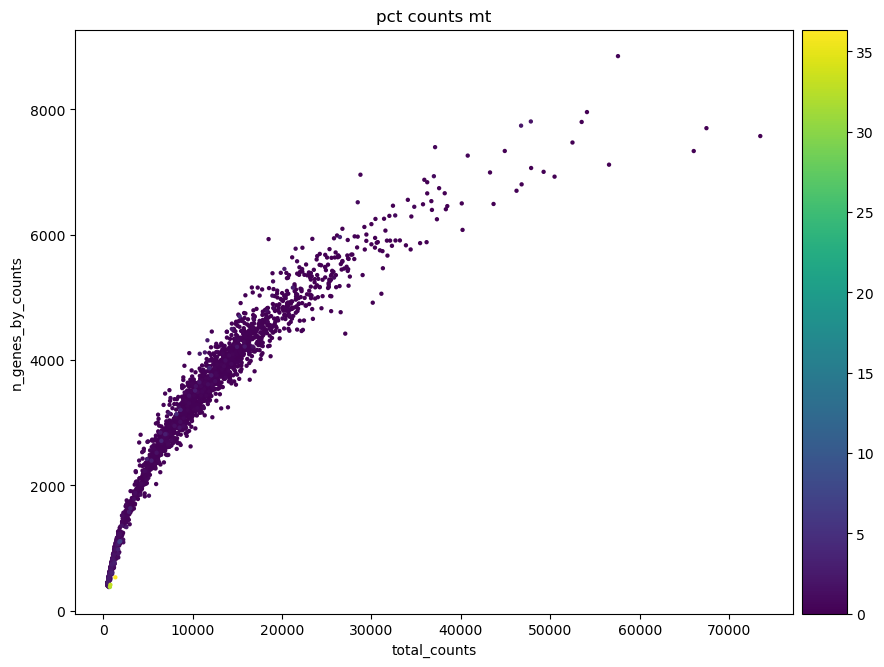

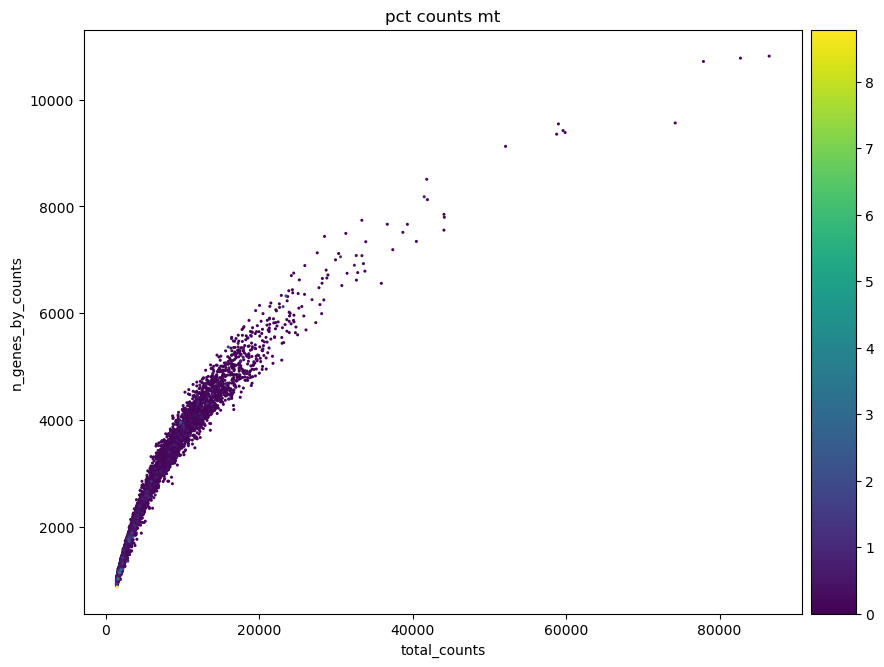

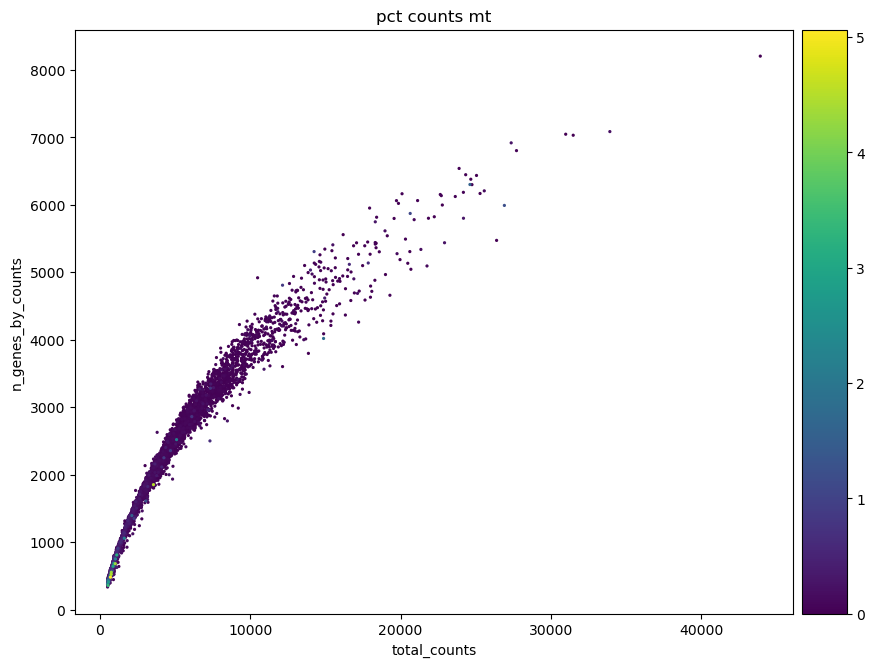

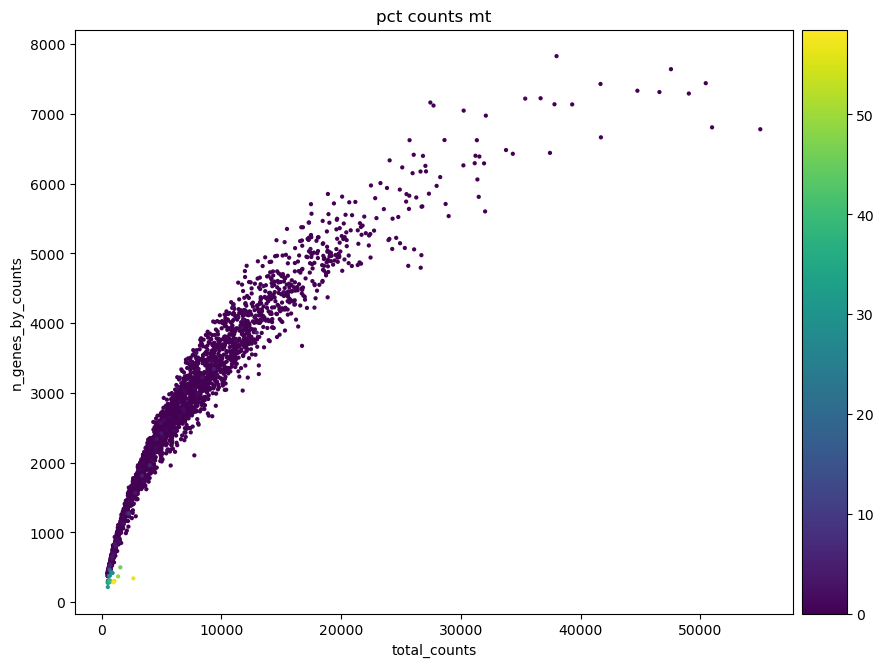

In [246]:
adata_CM_2D = adata[adata.obs["sample"] == "CM_2D"].copy()
adata_FB_2D = adata[adata.obs["sample"] == "FB_2D"].copy()
adata_FB_3D = adata[adata.obs["sample"] == "FB_3D"].copy()
adata_CM_FB_3D = adata[adata.obs["sample"] == "CM_FB_3D"].copy()


sc.pl.scatter(
    adata_CM_2D,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt",
    color_map="viridis"
)

sc.pl.scatter(
    adata_FB_2D,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt",
    color_map="viridis"
)

sc.pl.scatter(
    adata_FB_3D,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt",
    color_map="viridis"
)

sc.pl.scatter(
    adata_CM_FB_3D,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt",
    color_map="viridis"
)


###### Now based on this results we can come to conclusion that automatic thresholding based on given MAD should be more than enough for this analysis:

In [247]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * stats.median_abs_deviation(M)) | (
        np.median(M) + nmads * stats.median_abs_deviation(M) < M
    )
    return outlier

###### We apply this function to the `log1p_total_counts`, `log1p_n_genes_by_counts` and `pct_counts_in_top_20_genes` QC covariates each with a threshold of 5 MADs

In [248]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    17744
True       292
Name: count, dtype: int64

In [249]:
adata.write("microtissue_before_quality_control.h5ad")

###### mitochondrial outliers for sn nuclei - e.g. 3 MADs or >8%:

In [250]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    15041
True      2995
Name: count, dtype: int64

###### We now filter our AnnData object based on these two additional columns:

In [251]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 18036
Number of cells after filtering of low quality cells: 14787


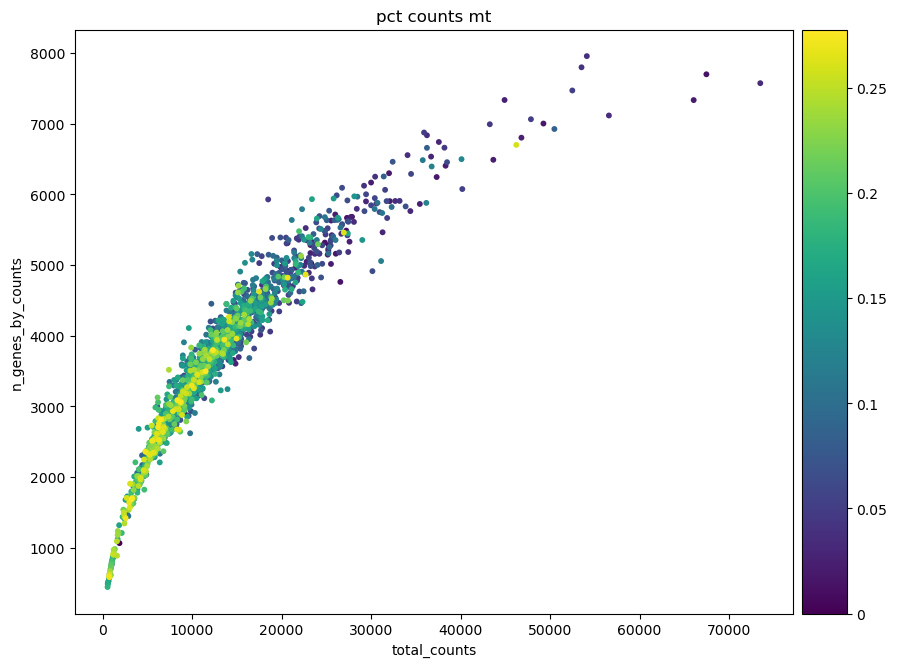

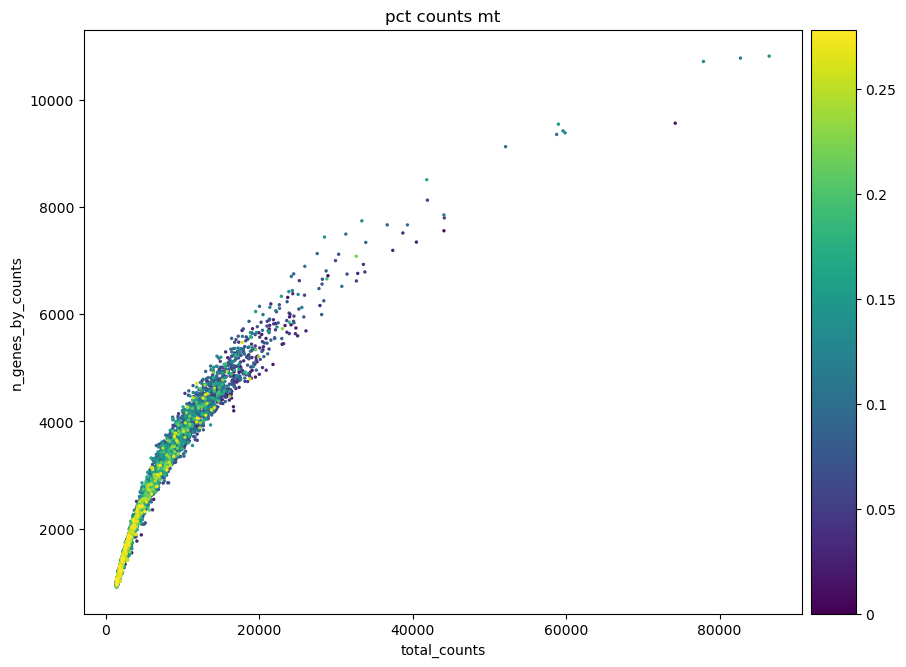

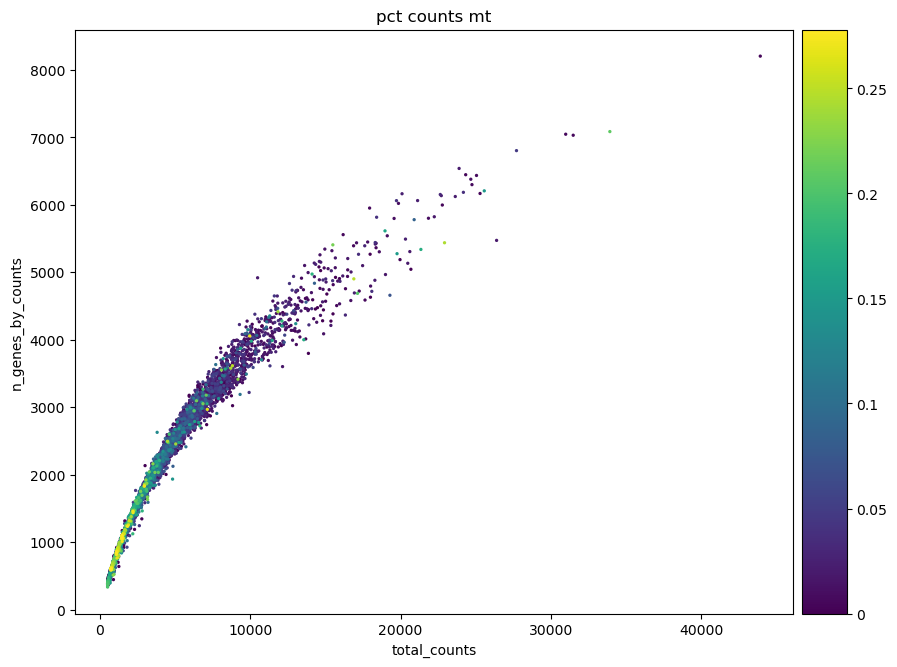

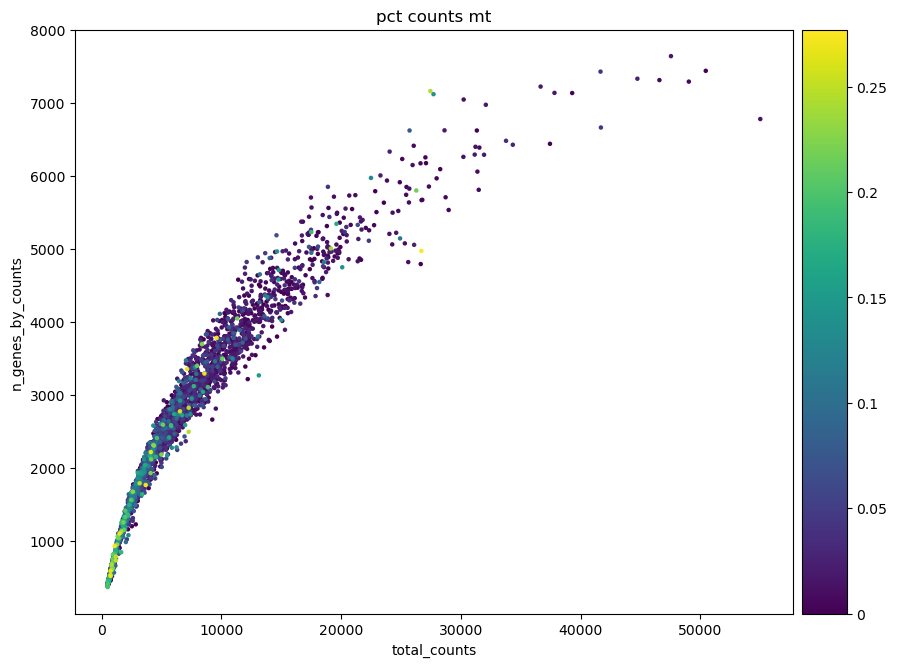

In [252]:
adata_CM_2D = adata[adata.obs["sample"] == "CM_2D"].copy()
adata_FB_2D = adata[adata.obs["sample"] == "FB_2D"].copy()
adata_FB_3D = adata[adata.obs["sample"] == "FB_3D"].copy()
adata_CM_FB_3D = adata[adata.obs["sample"] == "CM_FB_3D"].copy()


sc.pl.scatter(
    adata_CM_2D,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt",
    color_map="viridis"
)

sc.pl.scatter(
    adata_FB_2D,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt",
    color_map="viridis"
)

sc.pl.scatter(
    adata_FB_3D,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt",
    color_map="viridis"
)

sc.pl.scatter(
    adata_CM_FB_3D,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt",
    color_map="viridis"
)

###### Correction of ambient RNA:

###### We will do ambient RNA filtering by SoupX:

In [253]:
rcb.logger.setLevel(logging.ERROR)
anndata2ri_converter = anndata2ri.converter
pandas2ri_converter = pandas2ri.converter

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


###### Firstly we generate a copy of our AnnData object, normalize and log1p transform it:

###### Running SoupX:

###### Doublet detection

###### We first load some additional python and R packages:

In [21]:
%%R
#install.packages("ragg")
#BiocManager::install("scDblFinder")

NULL


In [140]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

In [254]:
data_mat = adata.X.T

In [255]:
data_dense = data_mat.toarray()

###### We can now launch the doublet detection by using data_dense as input to scDblFinder:

In [143]:
%%R -i data_dense -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts = data_dense),
    )
)

doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~11830 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1718 cells excluded from training.
iter=1, 1718 cells excluded from training.
iter=2, 1718 cells excluded from training.
Threshold found:0,35
1441 (9,7%) doublets called


In [256]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    13346
doublet     1441
Name: count, dtype: int64

###### Alright, let's save it as .h5ad file and go to normalization:

In [28]:
adata.write("microtissue_quality_control.h5ad")

###### Normalization:

###### We can now inspect the distribution of the raw_counts which we already did during QC:

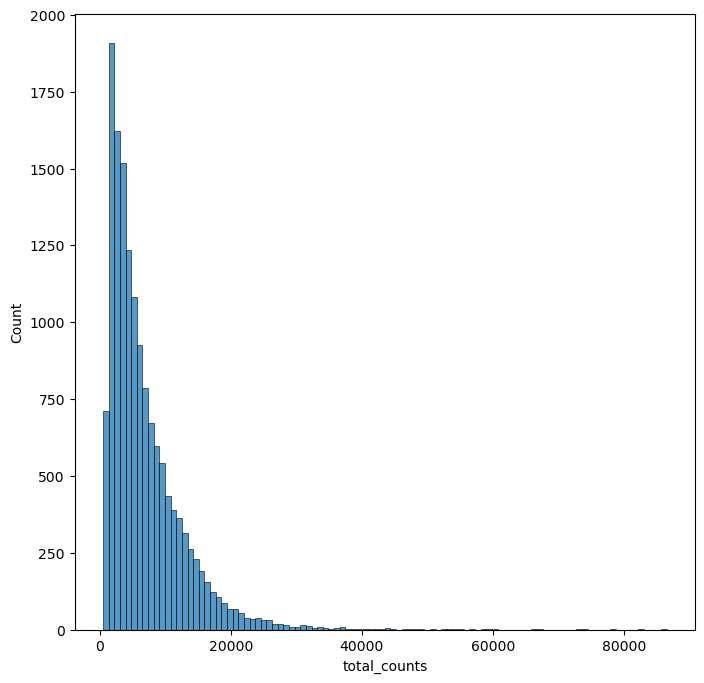

In [145]:
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

###### We will aply shifted logarithm as our normalization method of choice:

In [146]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

###### We can now inspect how the distribution of counts changed after we applied shifted logarithm

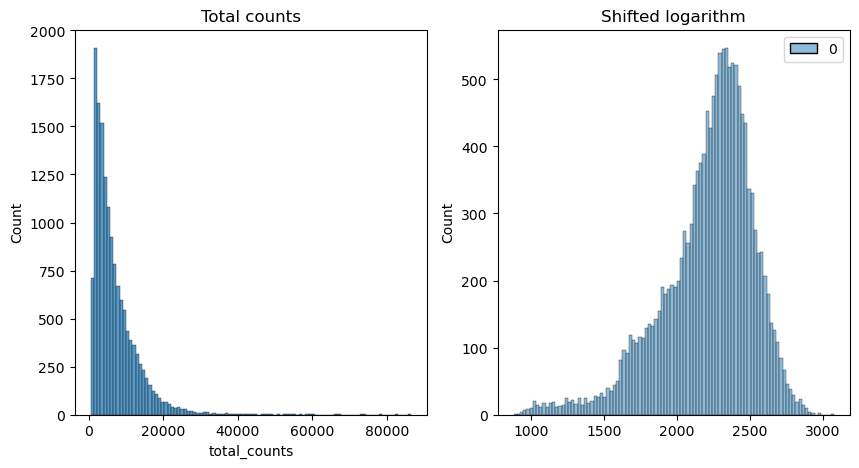

In [147]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [257]:
adata

AnnData object with n_obs × n_vars = 14787 × 38606
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

###### Now after normalization let's go to interesting features selection:

In [148]:
%%R 
#BiocManager::install("zellkonverter")
library(scry)
library(zellkonverter)
library(SingleCellExperiment)
library(patchwork)

###### Before QC:

<sys>:0: FutureWarning: Use varm (e.g. `k in adata.varm` or `adata.varm.keys() | {'u'}`) instead of AnnData.varm_keys, AnnData.varm_keys is deprecated and will be removed in the future.
<sys>:0: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.


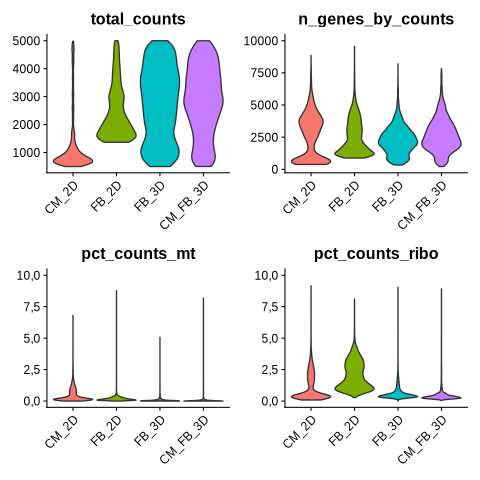

In [258]:
%%R

adata <- readH5AD("microtissue_before_quality_control.h5ad")

# 2. Konwertuj do SeuratObject
seurat_obj <- as.Seurat(adata, counts = "X", data=NULL)
#seurat_obj <- NormalizeData(seurat_obj) 

p1 <- VlnPlot(seurat_obj, features = "total_counts", group.by = "sample", pt.size = 0, y.max = 5000) +
      theme(axis.title.x = element_blank()) + NoLegend()

p2 <- VlnPlot(seurat_obj, features = "n_genes_by_counts", group.by = "sample", pt.size = 0, y.max = 10000) +
      theme(axis.title.x = element_blank()) + NoLegend()

p3 <- VlnPlot(seurat_obj, features = "pct_counts_mt", group.by = "sample", pt.size = 0, y.max = 10) +
      theme(axis.title.x = element_blank()) + NoLegend()

p4 <- VlnPlot(seurat_obj, features = "pct_counts_ribo", group.by = "sample", pt.size = 0, y.max = 10) +
      theme(axis.title.x = element_blank()) + NoLegend()

# 4. Połącz w layout 2x2
QC_pre_VlnPlots_zoom <- p1 + p2 + p3 + p4 + plot_layout(ncol = 2)

# 5. Wyświetl
QC_pre_VlnPlots_zoom

###### After QC:

In [259]:
adata = adata[
    (adata.obs["total_counts"] > 500) &
    (adata.obs["n_genes_by_counts"] > 2000),
].copy()

In [260]:
adata.write("microtissue_quality_control_v2.h5ad")

<sys>:0: FutureWarning: Use varm (e.g. `k in adata.varm` or `adata.varm.keys() | {'u'}`) instead of AnnData.varm_keys, AnnData.varm_keys is deprecated and will be removed in the future.
<sys>:0: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.


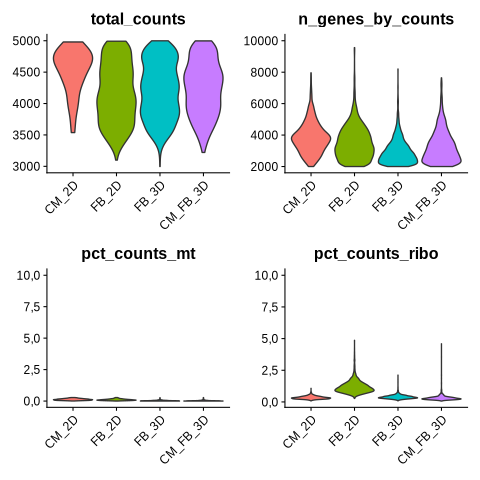

In [261]:
%%R

adata_v2 <- readH5AD("microtissue_quality_control_v2.h5ad")

# 2. Konwertuj do SeuratObject
seurat_obj_v2 <- as.Seurat(adata_v2, counts = "X", data=NULL)
#seurat_obj <- NormalizeData(seurat_obj) 

p1 <- VlnPlot(seurat_obj_v2, features = "total_counts", group.by = "sample", pt.size = 0, y.max = 5000) +
      theme(axis.title.x = element_blank()) + NoLegend()

p2 <- VlnPlot(seurat_obj_v2, features = "n_genes_by_counts", group.by = "sample", pt.size = 0, y.max = 10000) +
      theme(axis.title.x = element_blank()) + NoLegend()

p3 <- VlnPlot(seurat_obj_v2, features = "pct_counts_mt", group.by = "sample", pt.size = 0, y.max = 10) +
      theme(axis.title.x = element_blank()) + NoLegend()

p4 <- VlnPlot(seurat_obj_v2, features = "pct_counts_ribo", group.by = "sample", pt.size = 0, y.max = 10) +
      theme(axis.title.x = element_blank()) + NoLegend()

# 4. Połącz w layout 2x2
QC_pre_VlnPlots_zoom <- p1 + p2 + p3 + p4 + plot_layout(ncol = 2)

# 5. Wyświetl
QC_pre_VlnPlots_zoom

###### We can now directly call feature selection with deviance on the non-normalized counts matrix and export the binomial deviance values as a vector:

In [41]:
%%R
sce = devianceFeatureSelection(adata, assay="X")

In [44]:
from rpy2.robjects import r

In [45]:
binomial_deviance_r = r("rowData(sce)$binomial_deviance")

binomial_deviance = np.array(binomial_deviance_r)

binomial_deviance = binomial_deviance.reshape(-1, 1)

binomial_deviance.T

array([[ 19.3184057 ,  20.95898678,   0.        , ...,   0.        ,
        348.48784398, 194.17514968]], shape=(1, 38606))

###### As a next step we now sort the vector and select the top 4000 highly deviant genes and save them as an additional column in `.var` as 'highly_deviant

In [63]:
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance

###### Last, we visualize the feature selection results. We use a scanpy function for it:

In [66]:
sc.pp.highly_variable_genes(adata, layer="log1p_norm")

###### We inspect our results by plotting dispersion versus mean for the genes and color by 'highly_deviant':

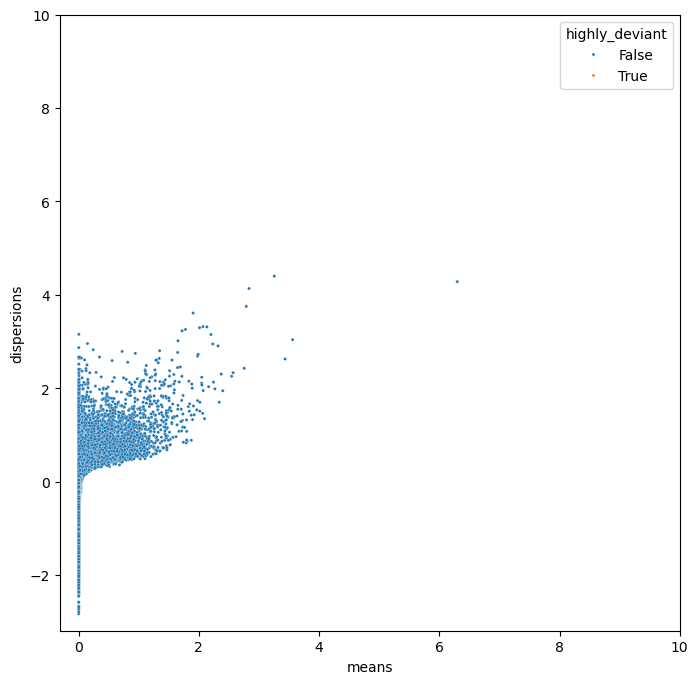

In [69]:
ax = sns.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5
)
ax.set_xlim(None, 10)
ax.set_ylim(None, 10)
plt.show()

In [70]:
adata.write("microtissue_feature_sel.h5ad")

###### PCA:

In [71]:
adata.X = adata.layers["log1p_norm"]

In [74]:
print(adata.var["highly_variable"].sum())

1


In [75]:
# setting highly variable as highly deviant to use scanpy 'use_highly_variable' argument in sc.pp.pca
adata.var["highly_variable"] = True
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)

/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


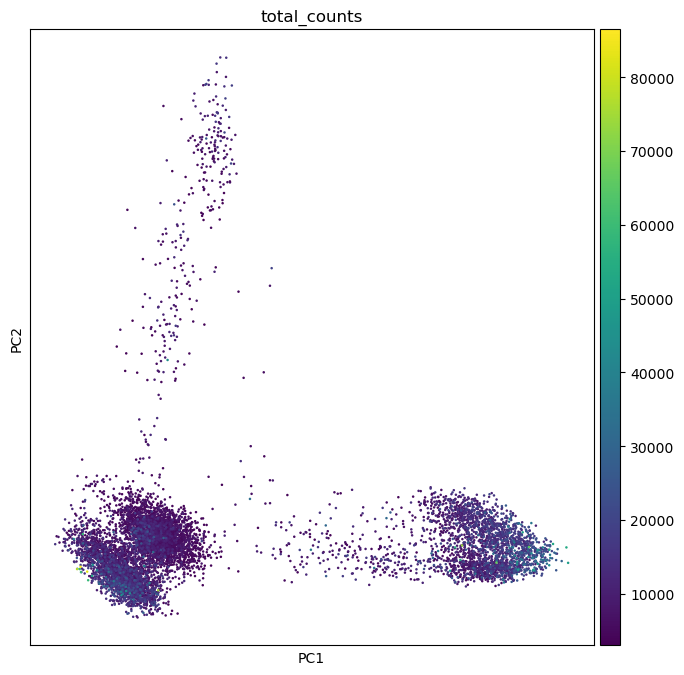

In [167]:
sc.pl.pca_scatter(adata_interesting, color="total_counts")

###### t-SNE

In [168]:
sc.tl.tsne(adata_interesting, use_rep="X_pca")

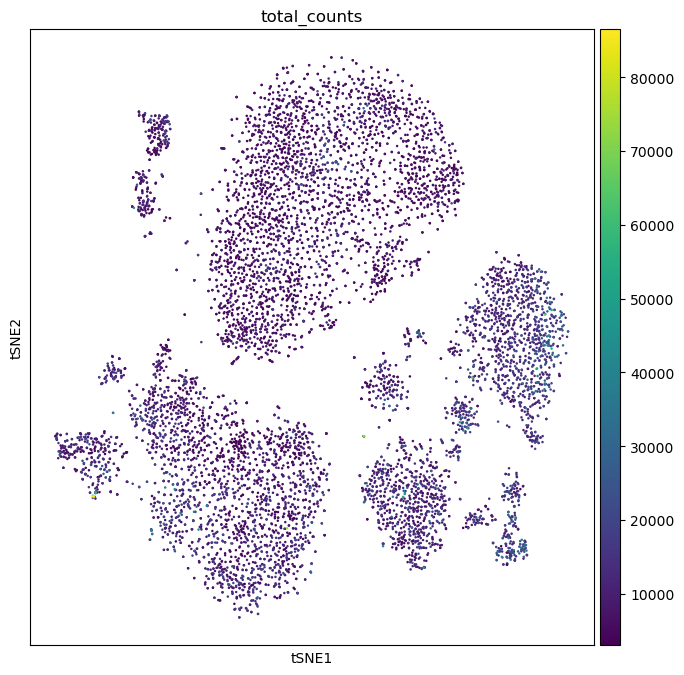

In [169]:
sc.pl.tsne(adata_interesting, color="total_counts")

###### UMAP:

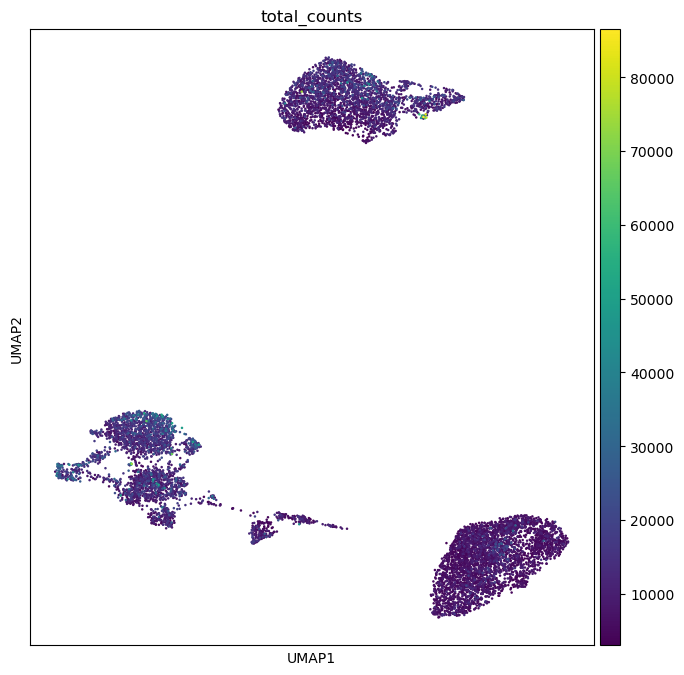

In [177]:
sc.pl.umap(adata_interesting, color="total_counts")

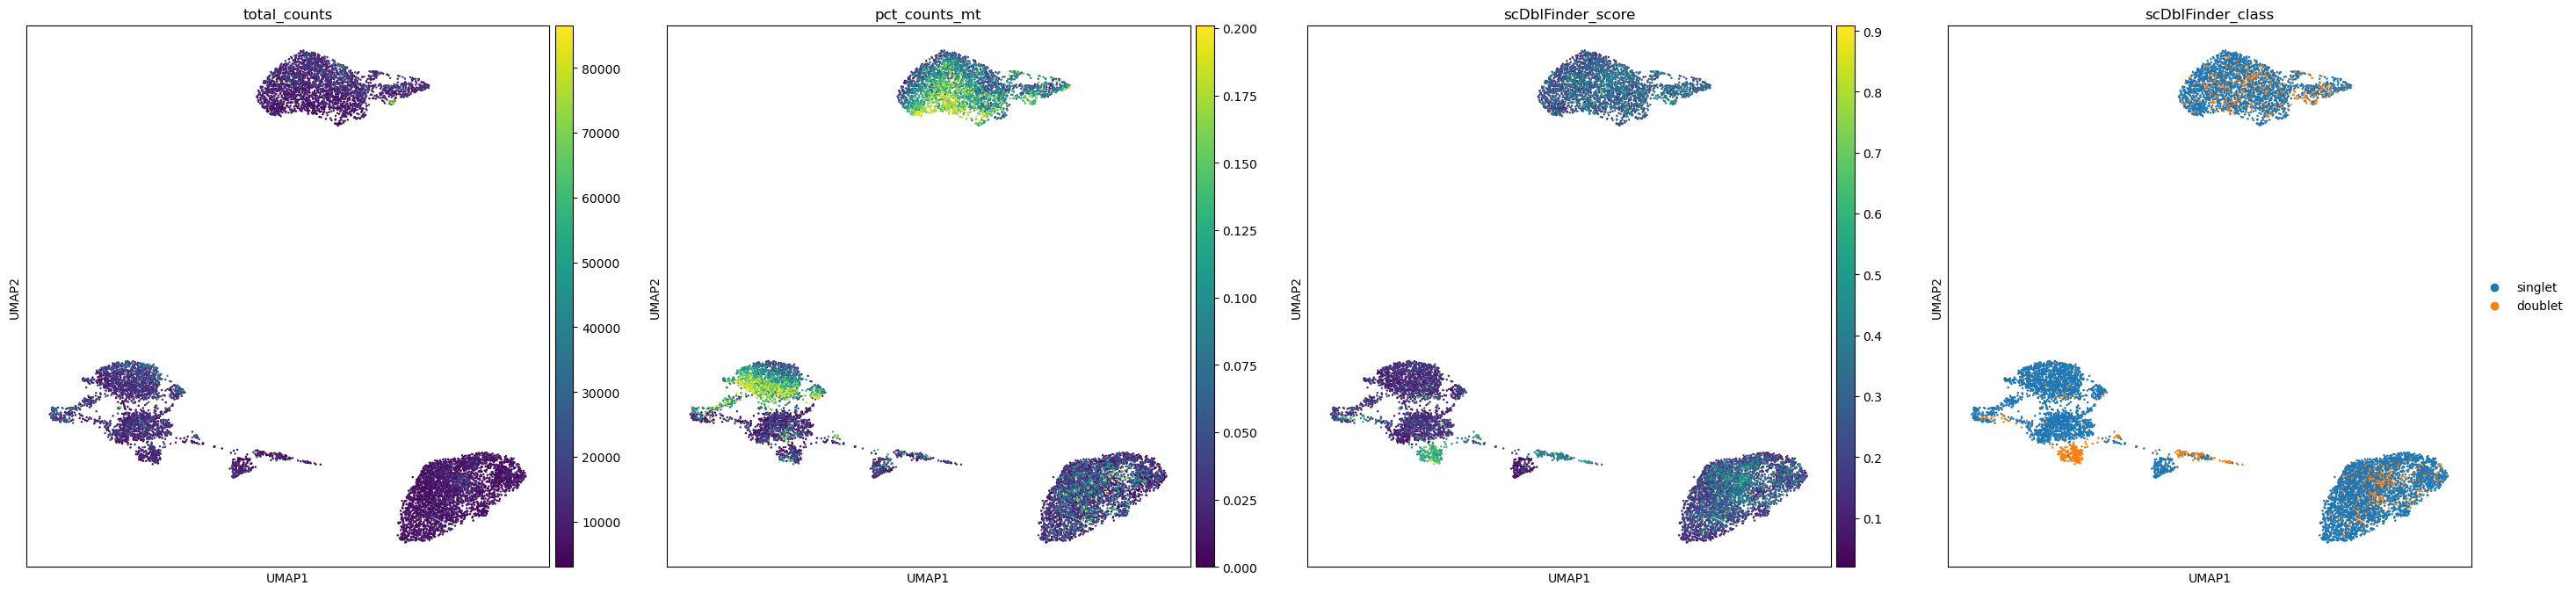

In [178]:
sc.pl.umap(
    adata_interesting,
    color=["total_counts", "pct_counts_mt", "scDblFinder_score", "scDblFinder_class"],
)

###### Integration and clustering from Gino Papers:

In [156]:
adatas_po_QC = {
    s: adata[adata.obs["sample"] == s].copy()
    for s in adata.obs["sample"].unique()
}

for key in adatas_po_QC:
    ad = adatas_po_QC[key]

    # 1. Normalizacja (odpowiednik części SCTransform)
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)

    # 2. Highly variable genes (odpowiednik return.only.var.genes = TRUE)
    sc.pp.highly_variable_genes(ad, flavor="seurat_v3", n_top_genes=3000)
    ad = ad[:, ad.var["highly_variable"]].copy()

    # 3. Regresja percent.mt
    sc.pp.regress_out(ad, ["pct_counts_mt"])

    # 4. Skalowanie
    sc.pp.scale(ad, max_value=10)

    adatas_po_QC[key] = ad

/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


In [157]:
hvg_sets = [
    set(ad.var_names)
    for ad in adatas_po_QC.values()
]

# przecięcie genów wspólnych dla wszystkich
common_features = set.intersection(*hvg_sets)

print(len(common_features))

582


###### 582 features is somehow low, we will do it another method:

In [271]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [273]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=3000,
    batch_key="sample"
)

/home/maksn/anaconda3/envs/DCM_cardio/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


In [272]:
adata.raw = adata

In [274]:
adata_interesting = adata[:, adata.var["highly_variable"]].copy()

In [277]:
print(adata_interesting.X[:5, :5]) 
print(adata_interesting.X.sum())
print(adata_interesting.X.min(), adata_interesting.X.max())
#print(np.isnan(adata_interesting.X).any())

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 0 stored elements and shape (5, 5)>
5.8081275e+06
0.0 6.9317355


In [161]:
sc.pp.regress_out(adata_interesting, ["pct_counts_mt"])

In [162]:
sc.pp.scale(adata_interesting, max_value=10)

In [163]:
sc.tl.pca(adata, svd_solver="arpack")

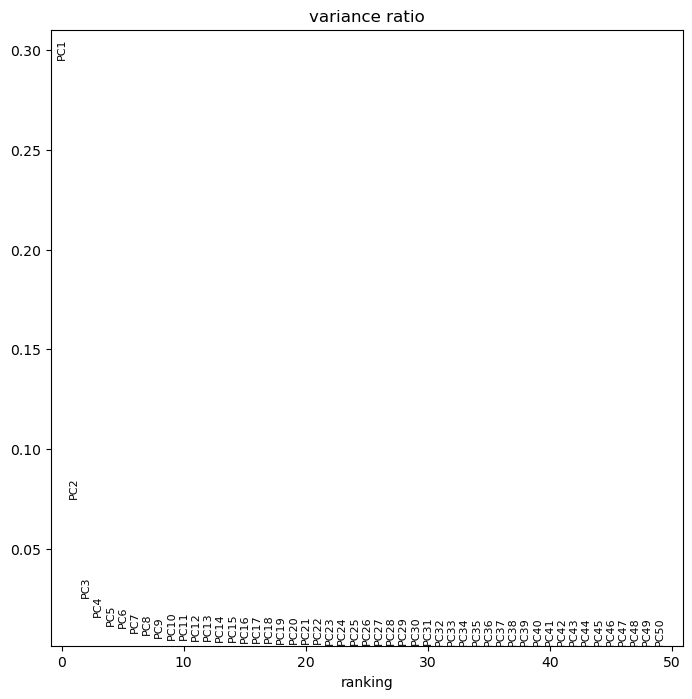

In [164]:
sc.pl.pca_variance_ratio(adata, n_pcs=50)

In [172]:
sc.pp.neighbors(adata_interesting, n_pcs=50)
sc.tl.umap(adata_interesting)

In [173]:
for res in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]:
    sc.tl.leiden(adata_interesting, resolution=res, key_added=f"leiden_{res}")

In [174]:
adata_interesting

AnnData object with n_obs × n_vars = 9205 × 3000
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'sample_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7',

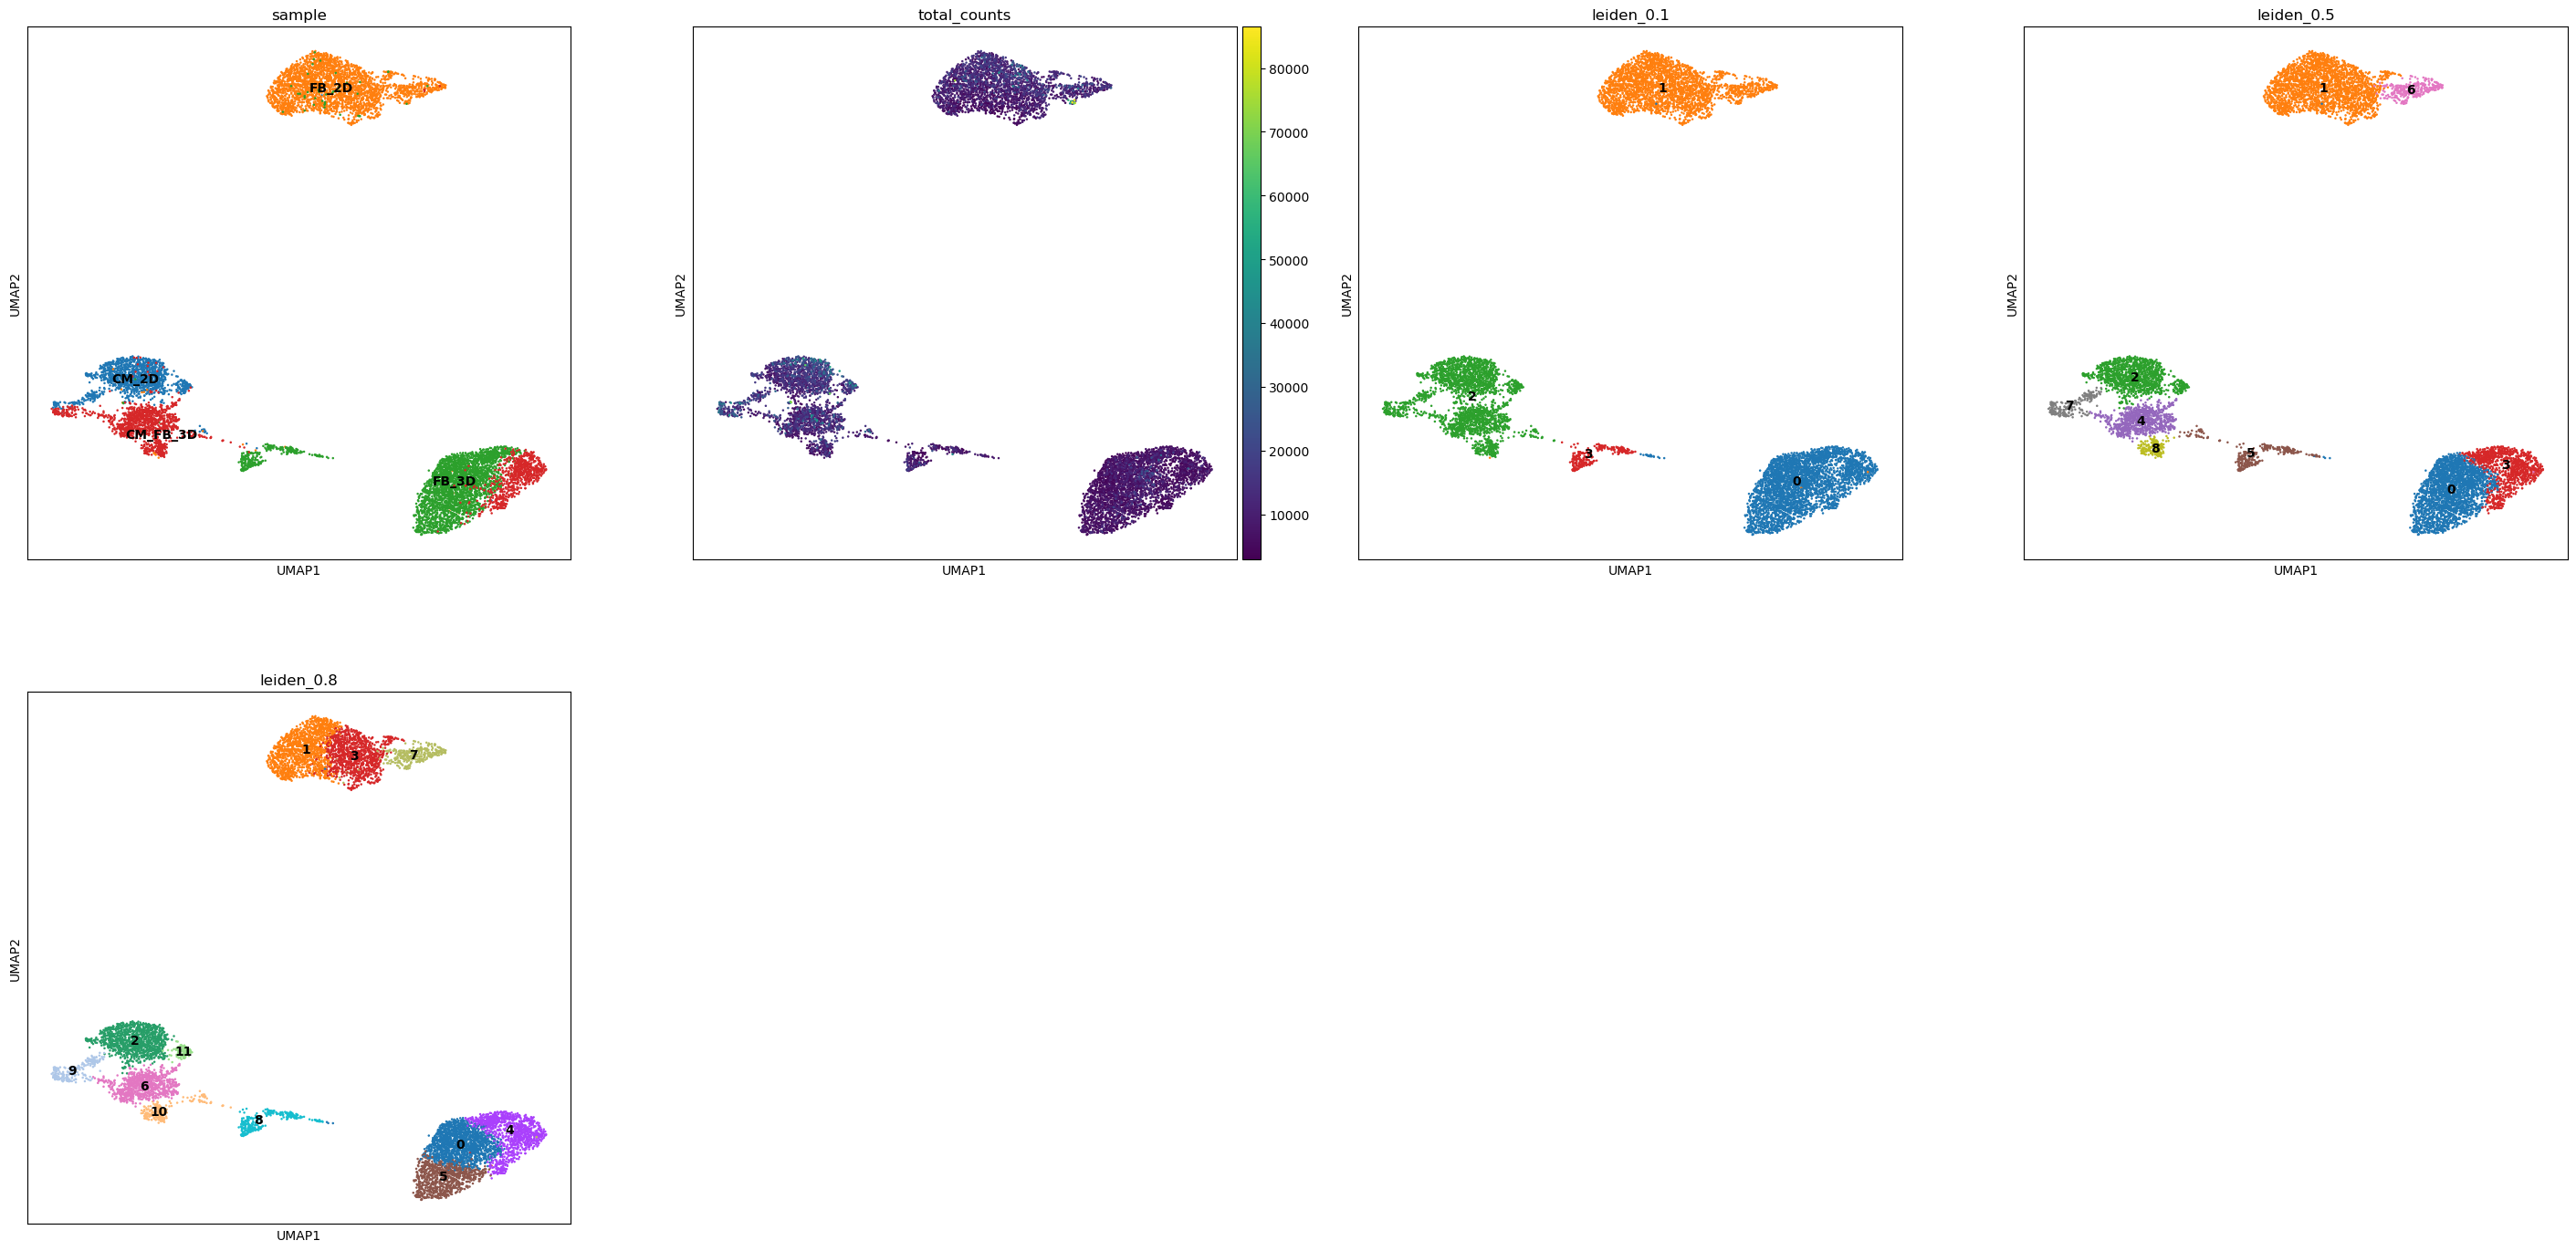

In [175]:
sc.pl.umap(
    adata_interesting,
    color=["sample", "total_counts", "leiden_0.1", "leiden_0.5", "leiden_0.8"],
    legend_loc="on data",
)

In [182]:
adata_plot = adata_interesting[np.random.permutation(adata_interesting.n_obs), :].copy()

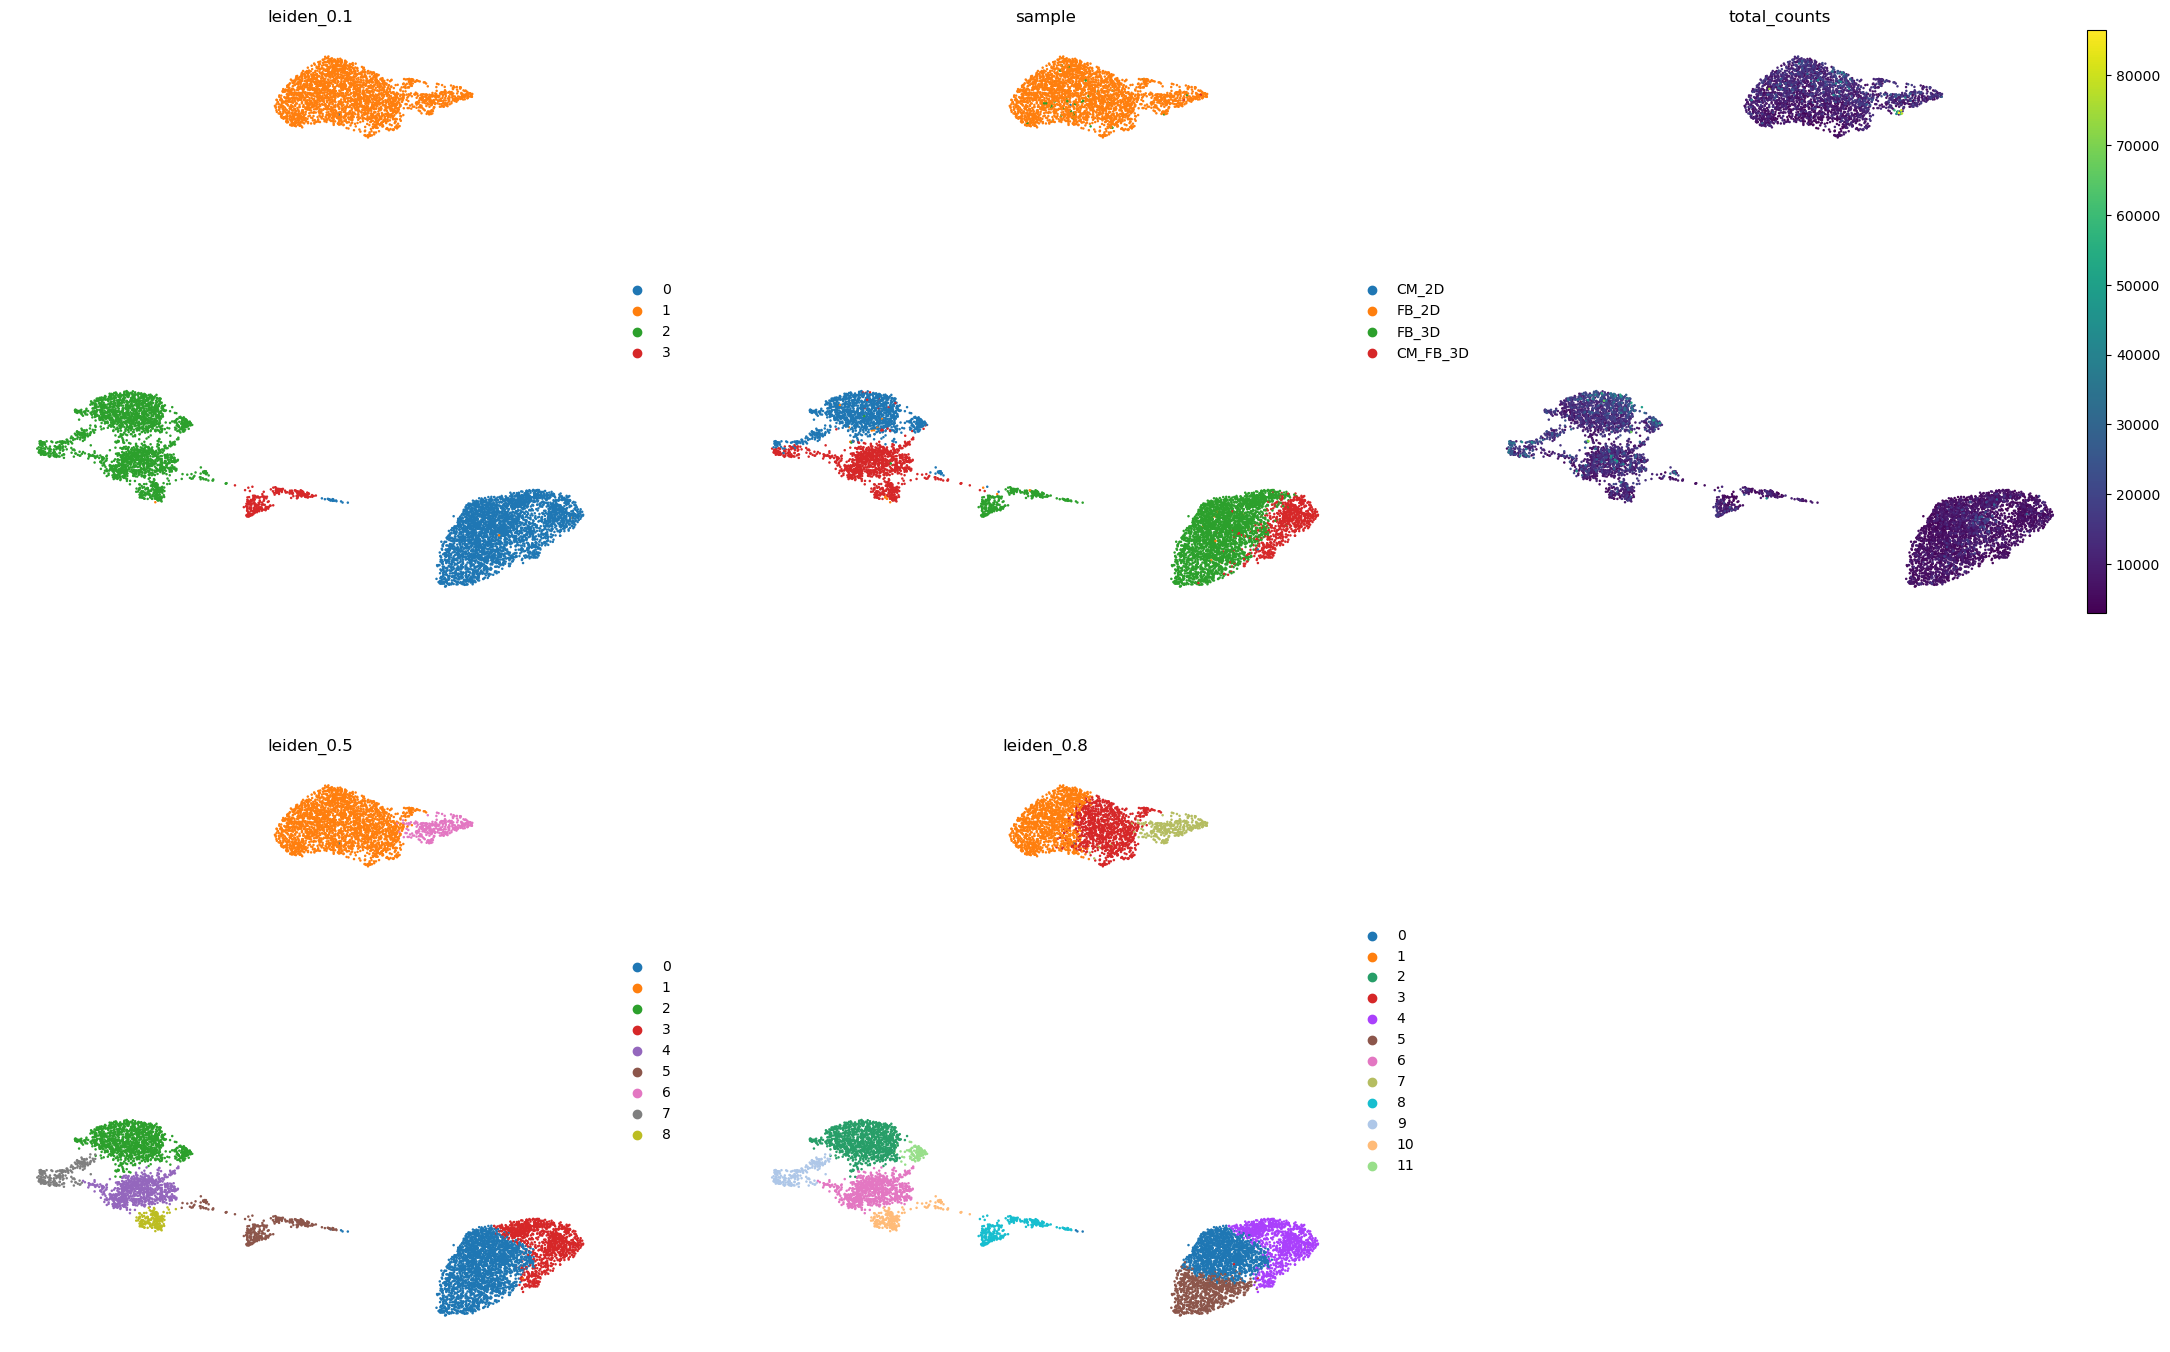

In [183]:
sc.pl.umap(
    adata_plot,
    color=[
        "leiden_0.1",
        "sample",
        "total_counts",
        "leiden_0.5",
        "leiden_0.8"
    ],
    ncols=3,
    frameon=False,
    legend_loc="right margin"
)

In [228]:
adata_interesting.write("microtissue_interesting.h5ad")

###### Cell annotation

In [278]:
import scanpy as sc
import scanpy.external as sce
import harmonypy as hm

In [279]:
sc.tl.pca(adata_interesting, n_comps=50, svd_solver='arpack')
print(adata_interesting.obsm['X_pca'].shape)

(9661, 50)


In [280]:
X = adata_interesting.obsm['X_pca']  # (n_obs, n_pcs)
meta = adata_interesting.obs           # DataFrame z kolumną 'sample'

harmony_out = hm.run_harmony(
    X,
    meta,
    ['sample']
)

# Zapisanie wyników w AnnData
adata_interesting.obsm['X_pca_harmony'] = harmony_out.Z_corr  # bez .T
print(adata_interesting.obsm['X_pca_harmony'].shape)

2026-02-12 15:48:57,188 - harmonypy - INFO - Running Harmony (PyTorch on cpu)
2026-02-12 15:48:57,188 - harmonypy - INFO -   Parameters:
2026-02-12 15:48:57,188 - harmonypy - INFO -     max_iter_harmony: 10
2026-02-12 15:48:57,189 - harmonypy - INFO -     max_iter_kmeans: 20
2026-02-12 15:48:57,189 - harmonypy - INFO -     epsilon_cluster: 1e-05
2026-02-12 15:48:57,189 - harmonypy - INFO -     epsilon_harmony: 0.0001
2026-02-12 15:48:57,190 - harmonypy - INFO -     nclust: 100
2026-02-12 15:48:57,190 - harmonypy - INFO -     block_size: 0.05
2026-02-12 15:48:57,190 - harmonypy - INFO -     lamb: [1. 1. 1. 1.]
2026-02-12 15:48:57,191 - harmonypy - INFO -     theta: [2. 2. 2. 2.]
2026-02-12 15:48:57,191 - harmonypy - INFO -     sigma: [0.1 0.1 0.1 0.1 0.1]...
2026-02-12 15:48:57,192 - harmonypy - INFO -     verbose: True
2026-02-12 15:48:57,192 - harmonypy - INFO -     random_state: 0
2026-02-12 15:48:57,192 - harmonypy - INFO -   Data: 50 PCs × 9661 cells
2026-02-12 15:48:57,192 - harmo

(9661, 50)


In [281]:
sc.pp.neighbors(adata_interesting, use_rep='X_pca_harmony')
sc.tl.umap(adata_interesting)

resolutions = [0.1, 0.5, 0.8]
for r in resolutions:
    sc.tl.leiden(adata_interesting, resolution=r, key_added=f'leiden_{r}')

In [282]:
adata_interesting

AnnData object with n_obs × n_vars = 9661 × 3000
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'leiden_0.1', 'leiden_0.5', 'leiden_0.8'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_0.1', 'leiden_0.5', 'leiden_0.8'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

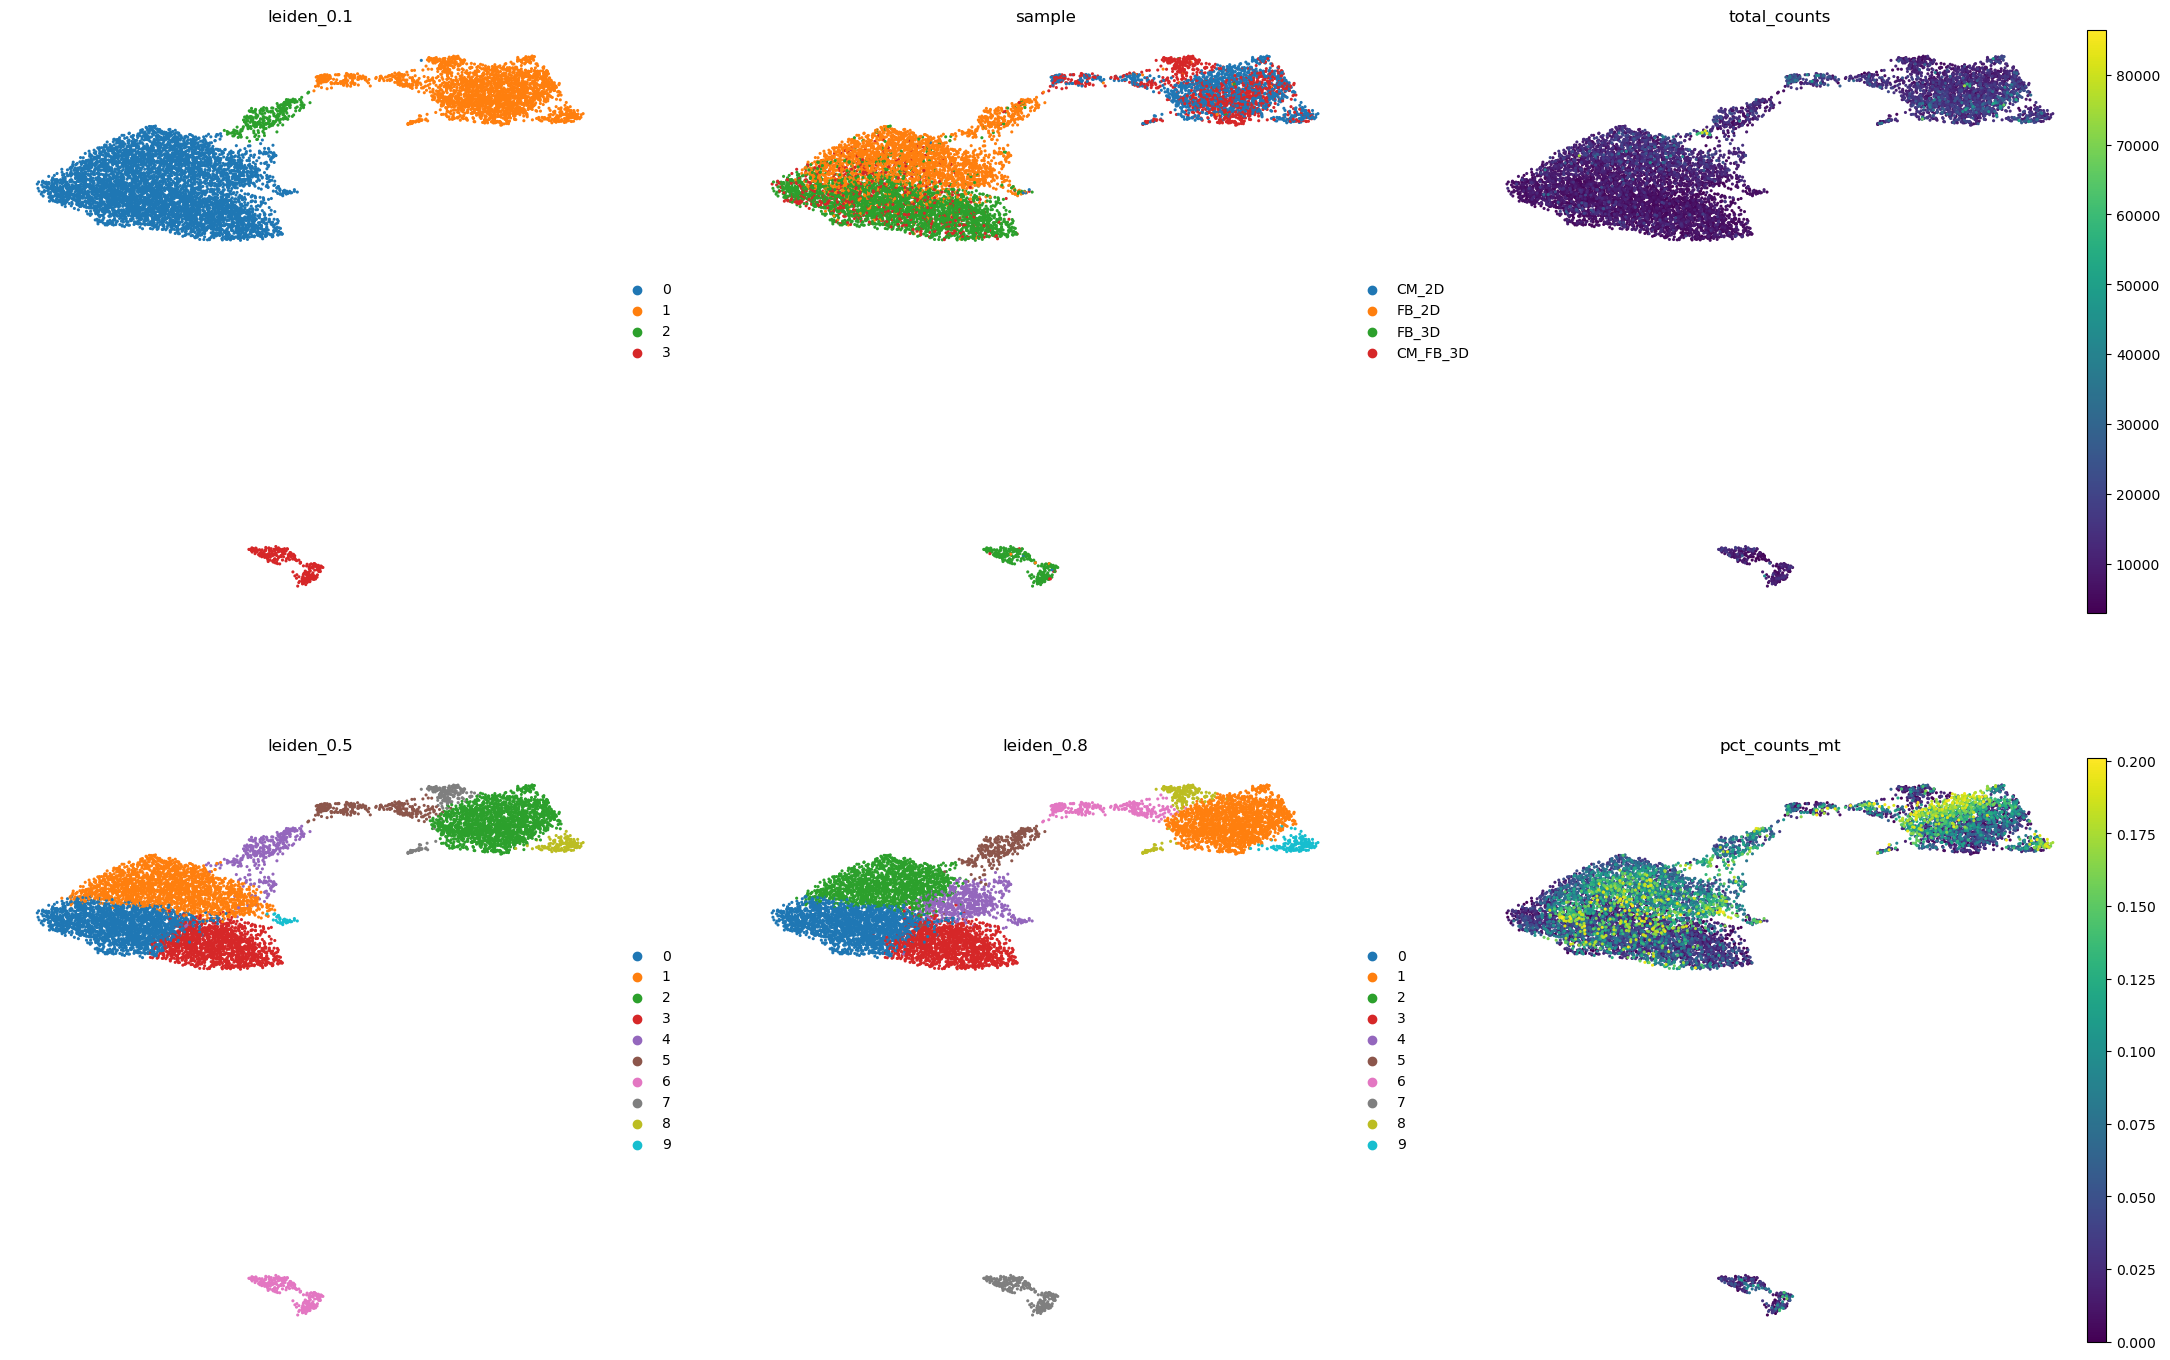

In [200]:
adata_plot = adata_interesting[np.random.permutation(adata_interesting.n_obs), :].copy()

# lista kolumn do wyświetlenia
group_by = ['leiden_0.1', 'sample', 'total_counts', 'leiden_0.5', 'leiden_0.8', 'pct_counts_mt']

# rysujemy w panelach (ncols=3)
sc.pl.umap(
    adata_plot,
    color=group_by,
    ncols=3,
    legend_loc='right margin',  # lub 'on data'
    frameon=False,
    size=20
)

In [283]:
adata_interesting.raw = adata_interesting  # domyślnie pełne RNA

# ---------------------------
# 2️⃣ Normalizacja
# ---------------------------
sc.pp.normalize_total(adata_interesting, target_sum=1e4)
sc.pp.log1p(adata_interesting)

# ---------------------------
# 3️⃣ Ustawienie identów / klastrów (jak Idents w Seurat)
# ---------------------------
# W Seurat było "SCT_snn_res.0.2"
cluster_key = 'leiden_0.1'  # dopasuj do swojego Scanpy clustering
adata_interesting.obs['cluster'] = adata_interesting.obs[cluster_key]

# ---------------------------
# 4️⃣ Find all markers (tylko pozytywne, min.pct=0.5, logfc.threshold=1)
# ---------------------------
sc.tl.rank_genes_groups(
    adata_interesting,
    groupby='cluster',
    method='t-test',        # lub 'wilcoxon'
    pts=True
)


In [284]:
# Pobranie wyników do DataFrame
markers = []
groups = adata_interesting.obs['cluster'].unique()
for g in groups:
    df = sc.get.rank_genes_groups_df(adata_interesting, group=g)
    # tylko pozytywne, min.pct >0.5 i logfc>1
    df = df[(df['logfoldchanges'] > 1) & (df['pct_nz_group'] > 0.5)]
    df['cluster'] = g
    markers.append(df)

markers_df = pd.concat(markers, ignore_index=True)
markers_df.to_csv('Microtissue_Markers_all_low_quality.csv', index=False)

# ---------------------------
# 5️⃣ Top 10 i top 3 genów wg logfc dla każdej grupy
# ---------------------------
markers_top10 = markers_df.groupby('cluster').apply(lambda x: x.nlargest(10, 'logfoldchanges')).reset_index(drop=True)
markers_top10.to_csv('microtissue_Markers_top10_low_quality.csv', index=False)

markers_top3 = markers_df.groupby('cluster').apply(lambda x: x.nlargest(3, 'logfoldchanges')).reset_index(drop=True)
markers_top3.to_csv('microtissue_Markers_top3_low_quality.csv', index=False)


/tmp/ipykernel_1957483/404213288.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  markers_top10 = markers_df.groupby('cluster').apply(lambda x: x.nlargest(10, 'logfoldchanges')).reset_index(drop=True)
/tmp/ipykernel_1957483/404213288.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  markers_top3 = markers_df.groupby('cluster').apply(lambda x: x.nlargest(3, 'logfoldchanges')).reset_index(drop=True)


In [285]:
# ---------------------------
# 6️⃣ Heatmap top 10 genów (losowe 20k komórek, jeśli masz więcej)
# ---------------------------
top_genes = markers_top10['names'].unique()
if adata_interesting.n_obs > 20000:
    idx = np.random.choice(adata_interesting.n_obs, 20000, replace=False)
    adata_sub = adata_interesting[idx, :].copy()
else:
    adata_sub = adata_interesting

# Pobranie danych RNA dla genów top10
data = adata_sub[:, top_genes].X
if isinstance(data, np.ndarray):
    df_heat = pd.DataFrame(data, columns=top_genes)
else:
    # jeśli sparse matrix
    df_heat = pd.DataFrame(data.toarray(), columns=top_genes)

# Znormalizuj do 0-1 na gen
df_heat = (df_heat - df_heat.min()) / (df_heat.max() - df_heat.min())

# Tworzymy kolorową mapę jak w R
cmap = sns.color_palette("RdBu_r", 256)

In [286]:
print(adata_interesting.raw.X[:5, :5])

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 0 stored elements and shape (5, 5)>


In [287]:
g = adata_interesting.obs['cluster'].unique()[0]  # pierwszy klaster
df = sc.get.rank_genes_groups_df(adata_interesting, group=g)

print(len(top_genes))
print(top_genes)
print(df.head(20))

40
['PLXDC1' 'CCDC102B' 'COL15A1' 'POSTN' 'PIEZO2' 'COL24A1' 'C7' 'HGF'
 'PPARG' 'DNM3OS' 'PSG4' 'ENSG00000287544' 'RXFP1' 'FST' 'SERPINE1'
 'CEMIP' 'SGK1' 'KIRREL3' 'ITGBL1' 'GCNT4' 'LRRTM3' 'ENSG00000268518'
 'ENSG00000287683' 'ENSG00000289973' 'ENSG00000289950' 'CTNND2' 'SORCS3'
 'TRIM55' 'LINC02552' 'MYBPC3' 'DIPK2B' 'TIE1' 'ANO2' 'ENSG00000289873'
 'CCDC88C' 'ROBO4' 'VWF' 'NR5A2' 'EMCN' 'MYCT1']
              names      scores  logfoldchanges  pvals  pvals_adj  \
0              MLIP  318.427612        8.037671    0.0        0.0   
1            CTNNA3  303.675781        7.157758    0.0        0.0   
2              LDB3  299.910583        7.966817    0.0        0.0   
3             MYOCD  295.769104        8.272471    0.0        0.0   
4            MYO18B  291.881378        8.133509    0.0        0.0   
5             TECRL  290.590454        7.730286    0.0        0.0   
6            MYBPC3  286.308350        8.582186    0.0        0.0   
7             RBM20  278.175720        8.325

/tmp/ipykernel_1957483/596342023.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r', 256)  # 'RdBu_r' = reversed RdBu


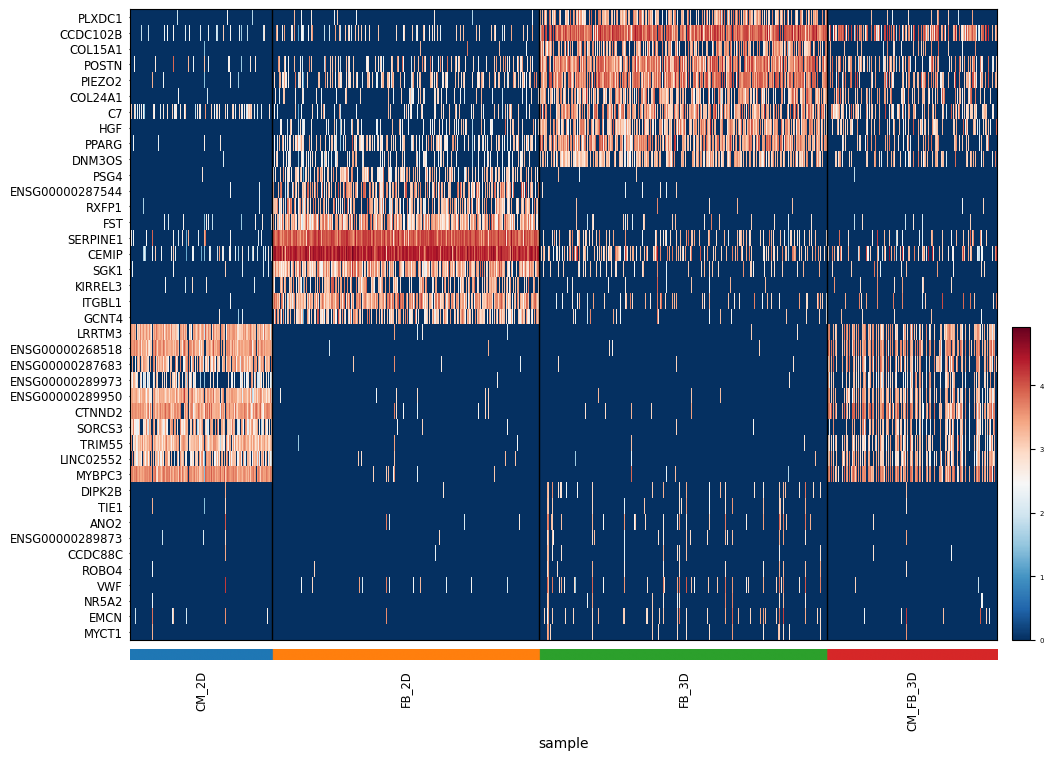

In [290]:
from matplotlib import cm
cmap = cm.get_cmap('RdBu_r', 256)  # 'RdBu_r' = reversed RdBu
# można też ręcznie odwrócić, ale RdBu_r jest już od czerwonego do niebieskiego

# -------------------------------
# 2️⃣ Losowe 20000 komórek (jeśli tyle masz)
# -------------------------------
if adata_interesting.n_obs > 20000:
    sampled_cells = np.random.choice(adata_interesting.obs_names, size=20000, replace=False)
else:
    sampled_cells = adata_interesting.obs_names

adata_sampled = adata_interesting[sampled_cells, :].copy()

# -------------------------------
# 3️⃣ Lista genów do heatmapy (top 10 markerów)
# -------------------------------
top_genes = markers_top10['names'].unique().tolist()

sc.pl.heatmap(
    adata_sampled,
    var_names=top_genes,
    groupby='sample',            # lub inny klucz klastrów
    use_raw=True,                 # analog SCT assay
    swap_axes=True,               # żeby geny w osi y jak w Seurat
    cmap=cmap,
    show=False
)

# Dodatkowa stylizacja jak w R
plt.gca().tick_params(axis='y', labelsize=5)  # wielkość tekstu
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)  # marginesy
plt.show()

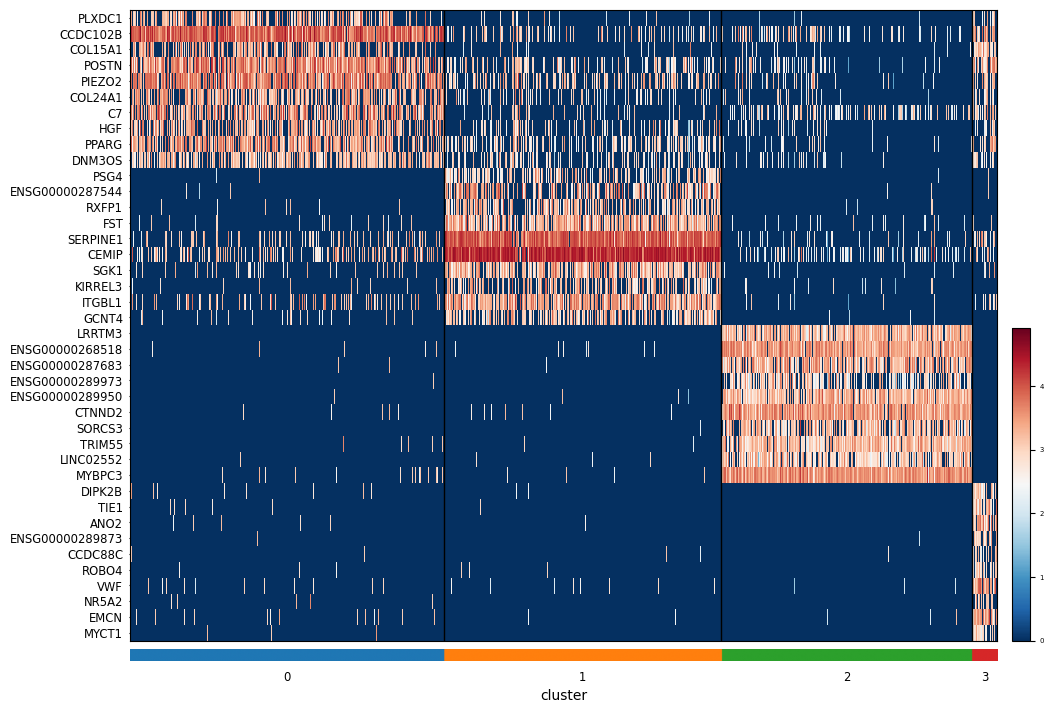

In [291]:
sc.pl.heatmap(
    adata_sampled,
    var_names=top_genes,
    groupby='cluster',            # lub inny klucz klastrów
    use_raw=True,                 # analog SCT assay
    swap_axes=True,               # żeby geny w osi y jak w Seurat
    cmap=cmap,
    show=False
)

# Dodatkowa stylizacja jak w R
plt.gca().tick_params(axis='y', labelsize=5)  # wielkość tekstu
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)  # marginesy
plt.show()

In [293]:
adata_interesting

AnnData object with n_obs × n_vars = 9661 × 3000
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'leiden_0.1', 'leiden_0.5', 'leiden_0.8', 'cluster'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_0.1', 'leiden_0.5', 'leiden_0.8', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

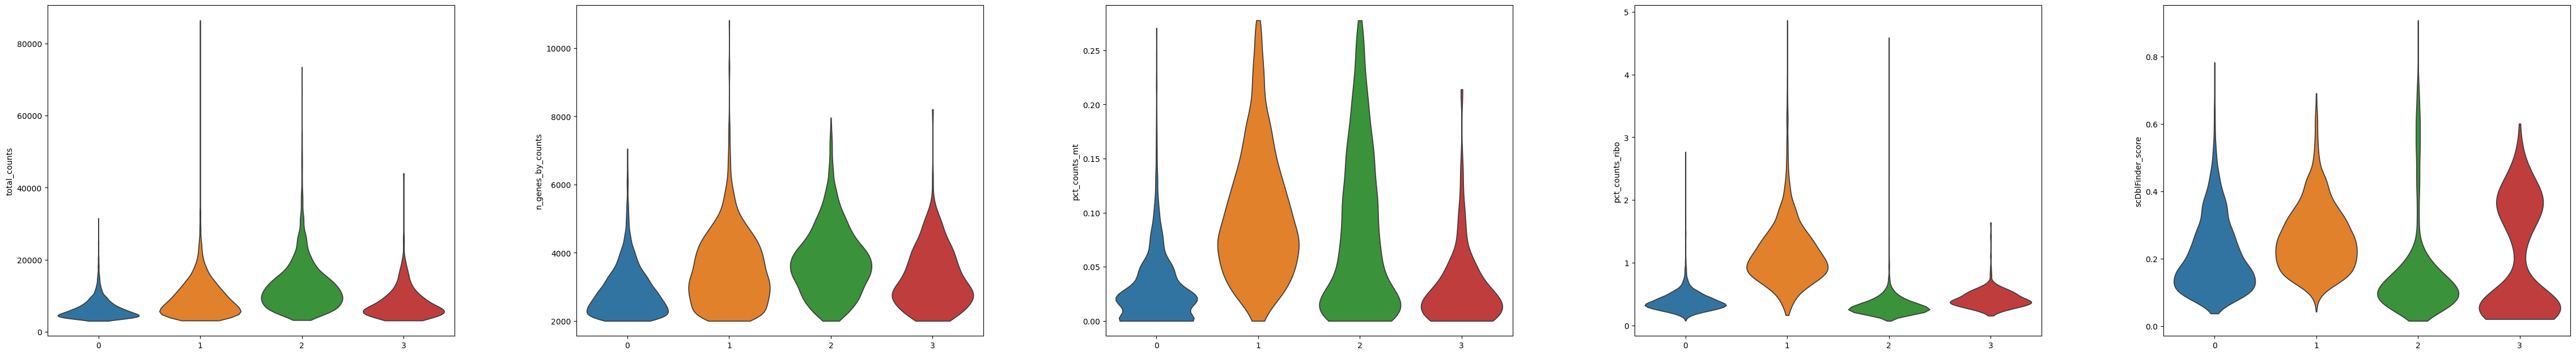

In [294]:
features = ['total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo', 'scDblFinder_score']

# Rysowanie violin plot
sc.pl.violin(
    adata_interesting,           # analog DCM_RV
    keys=features,               # kolumny z adata.obs lub geny w adata.raw.var_names
    groupby='cluster',           # jeśli chcesz podzielić po klastrach
    multi_panel=True,            # osobne panele jak w ncol=3
    rotation=0,                  # obrót etykiet
    size=0,                      # pt.size=0 → nie rysuj punktów pojedynczych komórek
    show=False
)

# Usuń tytuł osi X, analog theme(axis.title.x = element_blank())
plt.xlabel('')
plt.show()